In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline
sns.set_color_codes()

In [2]:
table1 = Table.read("Halpha-DR3_errorFlag_3f_16r.ecsv", format="ascii.ecsv")
table2 = Table.read("Halpha-DR3_errorFlag_3f_16r18.ecsv", format="ascii.ecsv")
table3 = Table.read("Halpha-DR3_errorFlag_3f_18r20.ecsv", format="ascii.ecsv")
table4 = Table.read("Halpha-DR3_errorFlag_3f_20r21.ecsv", format="ascii.ecsv")

In [3]:
# Merge tall four tables
table_merge = vstack([table1, table2, table3, table4])
len(table_merge)

9431

In [4]:
table_merge.colnames 

['Unnamed: 0',
 'Field',
 'ID',
 'RA',
 'DEC',
 'FWHM',
 'ISOarea',
 'KRON_RADIUS',
 'nDet_magPStotal',
 'PhotoFlagDet',
 'U_PStotal',
 'F378_PStotal',
 'F395_PStotal',
 'F410_PStotal',
 'F430_PStotal',
 'G_PStotal',
 'F515_PStotal',
 'R_PStotal',
 'F660_PStotal',
 'I_PStotal',
 'F861_PStotal',
 'Z_PStotal',
 'e_U_PStotal',
 'e_F378_PStotal',
 'e_F395_PStotal',
 'e_F410_PStotal',
 'e_F430_PStotal',
 'e_G_PStotal',
 'e_F515_PStotal',
 'e_R_PStotal',
 'e_F660_PStotal',
 'e_I_PStotal',
 'e_F861_PStotal',
 'e_Z_PStotal',
 'r - i',
 'r - J0660',
 'e(r - i)',
 'e(r - J0660)',
 'Unnamed: 0.1']

In [5]:
table_merge.write("Emission_lines_dr3.ecsv", format="ascii.ecsv")

In [6]:
cx = table_merge["r - i"]
cy = table_merge["r - J0660"]

In [7]:
#New color
cz = table_merge["F515_PStotal"] - table_merge["F660_PStotal"] 

In [8]:
# Mask to choose the strong Halpha emiters with large FWHM
m1 = cy > 1.2
#m2 = cx <= 0.0
m3 = table_merge["FWHM"] > 8.0
m4 = cz > 1.5
mask = m1 & m3 & m4

In [9]:
table_emg = table_merge[mask]
table_emg

Unnamed: 0,Field,ID,RA,DEC,FWHM,ISOarea,KRON_RADIUS,nDet_magPStotal,PhotoFlagDet,U_PStotal,F378_PStotal,F395_PStotal,F410_PStotal,F430_PStotal,G_PStotal,F515_PStotal,R_PStotal,F660_PStotal,I_PStotal,F861_PStotal,Z_PStotal,e_U_PStotal,e_F378_PStotal,e_F395_PStotal,e_F410_PStotal,e_F430_PStotal,e_G_PStotal,e_F515_PStotal,e_R_PStotal,e_F660_PStotal,e_I_PStotal,e_F861_PStotal,e_Z_PStotal,r - i,r - J0660,e(r - i),e(r - J0660),Unnamed: 0.1
int64,str13,str25,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
21712,SPLUS-s03s05,iDR3.SPLUS-s03s05.040546,330.5388749847869,-2.0097191021677627,17.118303,757,2.7668513999999997,12.0,0,23.310904,23.031225,18.214845999999998,17.42765,16.668136999999998,16.550383,14.9585905,15.169159,13.078664999999999,14.211617000000002,12.882533,12.874711999999999,1.4336061000000002,1.6920118000000002,0.046342827,0.025772905,0.016235175,0.0072820773,0.006493633,0.0028284309,0.0012152003,0.0018240481,0.0015611210999999998,0.0011082239999999999,0.9575419999999983,2.0904940000000014,0.0033655865502447593,0.0030784303021499284,--
188941,HYDRA-0065,iDR3.HYDRA-0065.000118,159.9566993632784,-31.55664700403079,10.633800500000001,289,3.2670162,12.0,0,21.238148000000002,19.03465,17.77413,17.157593,16.909492,16.319110000000002,17.50338,16.50874,15.187512,14.953944,15.069479000000001,15.059187,0.24603229999999998,0.07921133,0.026467052999999997,0.015981972,0.013105461,0.0055863084,0.022503733999999997,0.005859294399999999,0.003588432,0.0029386198,0.0050118426,0.0037377195,1.5547959999999996,1.3212279999999996,0.0065549078708112595,0.00687082055394371,--
503731,HYDRA-0127,iDR3.HYDRA-0127.000745,162.65716232137473,-41.187267548973885,11.319782,348,3.3276540999999997,7.0,2,99.0,99.0,99.0,99.0,27.956265999999996,26.390759999999997,99.0,17.022717,15.527384,16.740883,15.204410999999999,15.09314,22.571629,22.05855,21.451979,21.574701,156.02792,11.864286,21.883707,0.006200888000000001,0.0034799776,0.0057769909999999996,0.004612937,0.0031941753999999998,0.2818339999999999,1.4953330000000005,0.008474941710868872,0.007110643858684372,--
9230,SPLUS-s20s35,iDR3.SPLUS-s20s35.036033,334.3402331351376,-24.88095342223036,13.533273000000001,138,3.3289470000000003,12.0,2,17.651598,17.31985,17.500675,17.691534,16.756874,18.281862,17.392595,17.493076000000002,15.838176999999998,15.883977999999999,15.678532,15.685362,0.013715086000000001,0.01730822,0.029390742999999997,0.03099944,0.017918548,0.016495546,0.019966673,0.009076104,0.0044770692,0.0041579786,0.00693735,0.0050221816999999995,1.609098000000003,1.654899000000004,0.009983208394943679,0.010120267409530473,--
110315,SPLUS-s28s48,iDR3.SPLUS-s28s48.000391,317.0396898099512,-36.901148177792564,29.599075,544,3.4659317,12.0,2,16.88543,16.524283999999998,16.672104,16.816679999999998,16.70961,15.73432,17.166714000000002,16.113297,14.726984,16.667332000000002,15.258479999999999,15.179170999999998,0.0098468205,0.011658231000000002,0.018107334,0.017382853,0.016159937,0.0040633488,0.016287053,0.0042429026,0.0027420437,0.0072543419999999996,0.005767621999999999,0.0043223524,-0.5540350000000025,1.3863129999999995,0.008404028815160664,0.005051833936878414,--
203995,SPLUS-n18s10,iDR3.SPLUS-n18s10.000071,163.75072930133163,-23.62601103679027,8.819875999999999,215,3.5384822,12.0,2,22.85855,21.199963,20.603113,19.581635000000002,19.592012,17.236967,17.85397,17.365276,15.96214,16.062754,15.597570000000001,16.004332,0.9904171999999999,0.29435915,0.29287870000000005,0.10653894400000001,0.09895119,0.008694526,0.02523898,0.00911825,0.004934822,0.004839394,0.0066803037,0.006272528,1.3025219999999997,1.4031360000000017,0.01032289772058873,0.010367977200697539,--
115925,SPLUS-n12s34,iDR3.SPLUS-n12s34.000018,196.96377110056733,-15.585766592627742,16.584972,116,3.8958654000000004,10.0,2,

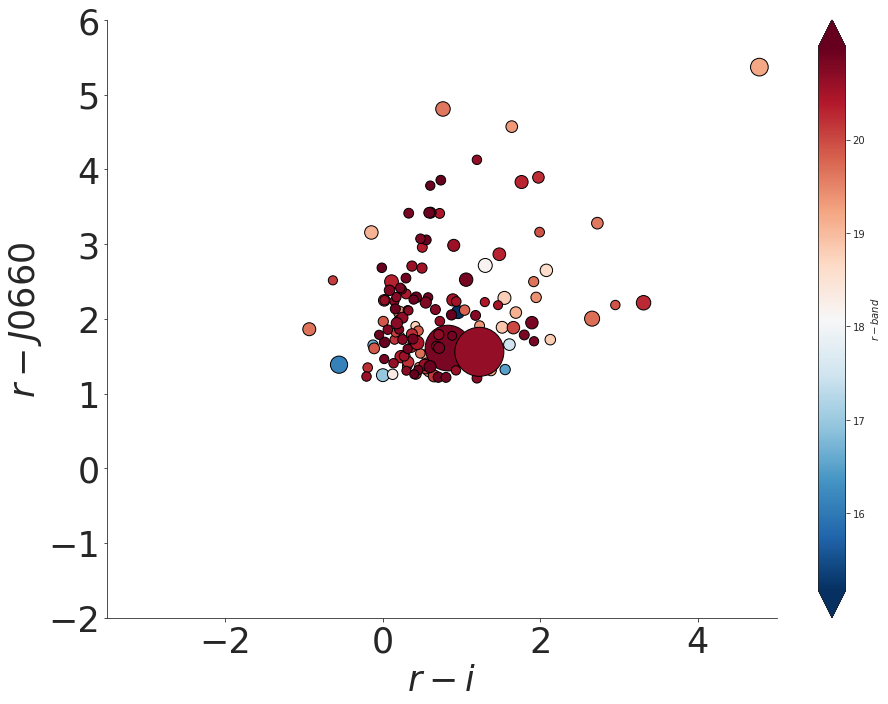

In [10]:
color_palette = sns.color_palette('Paired', 55)
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    plt.xlabel(r"$r - i$", fontsize=35)
    plt.ylabel(r"$r - J0660$", fontsize=35)
    plt.tick_params(axis='x', labelsize=35) 
    plt.tick_params(axis='y', labelsize=35)
    scat = ax.scatter(table_emg["r - i"], table_emg["r - J0660"], s=10*table_emg["FWHM"], edgecolor='black',
                             c=table_emg["R_PStotal"], zorder = 2, cmap='RdBu_r')
    #pal = sns.dark_palette("magma", as_cmap=True)
    #pal = sns.cubehelix_palette(as_cmap=True)
    pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
    #pal = sns.color_palette("Paired", 19, as_cmap=True)
    #pal = sns.color_palette("bright")
    #ax = sns.kdeplot(B1, A1, zorder = 2, cmap=pal);
    #ax2.plot(fit_line, 0.42917 * fit_line - 0.04333, color="k", ls="--")
    ax.set(
      xlim=[-3.5, 5.],
      ylim=[-2.0, 6.])
    fig.colorbar(scat,extend='both', ax=ax).set_label("$r-band$")
    #ax.set_aspect("equal")
    #ax.set_title(r"(r - J0660) vs (r - i)")

In [11]:
from astroML.crossmatch import crossmatch_angular
# coordinates
ra = table_merge["RA"]
dec = table_merge["DEC"]

spX = np.array(list(zip(ra, dec)))
spX[:, 0] = ra
spX[:, 1] = dec

# mask 
ra_ngc = 54.621179
dec_ngc = -35.45074

ngX = np.empty((1, 2), dtype=np.float64)
ngX[:, 0] = ra_ngc
ngX[:, 1] = dec_ngc
c = SkyCoord(ra=ra_ngc*u.degree, dec=dec_ngc*u.degree)
c.to_string('hmsdms')

ngc1399 = Table([ngX[:, 0], ngX[:, 1]], names=('RA', 'DEC'), meta={'name': 'first table'})
ngc1399.write("ngc1399_coordinates.dat", format="ascii")

In [13]:
# Find the SDSS object on the SPLUS list, makes crossmacth using 2 arcsec 
max_radius = 200  # 6 degrees
#dist, ind = crossmatch_angular(sdX, spX, max_radius)
#table_merge[ind]

In [18]:
#table_fornax = table_merge[mask_f]
#table_fornax

In [19]:
df_emg = table_emg.to_pandas()
df_emg.describe()

/home/luis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'Unnamed: 0.1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,RA,DEC,FWHM,ISOarea,KRON_RADIUS,nDet_magPStotal,PhotoFlagDet,U_PStotal,F378_PStotal,...,e_R_PStotal,e_F660_PStotal,e_I_PStotal,e_F861_PStotal,e_Z_PStotal,r - i,r - J0660,e(r - i),e(r - J0660),Unnamed: 0.1
count,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,94.000000
mean,1.362513e+06,201.225862,-22.128223,14.609943,97.914286,4.725272,10.735714,0.964286,36.777811,41.214509,...,0.086443,0.021818,0.072646,0.641830,0.148016,0.754471,2.080038,0.115483,0.089636,207654.127660
std,1.108555e+06,95.043641,16.035547,25.753464,266.834265,1.515524,1.543661,2.321035,29.890972,33.521803,...,0.049923,0.014990,0.050362,3.096724,0.483923,0.786034,0.778354,0.066616,0.051285,170213.742265
min,6.771000e+03,6.577494,-58.946134,8.016614,3.000000,1.820000,4.000000,0.000000,16.801247,16.524284,...,0.002828,0.001215,0.001824,0.001561,0.001108,-0.931682,1.206089,0.003366,0.003078,210.000000
25%,2.760022e+05,155.640369,-34.746889,8.952567,15.750000,3.765280,10.000000,0.000000,21.846384,21.398454,...,0.043318,0.011087,0.028259,0.023687,0.024910,0.252093,1.512485,0.058185,0.045086,55744.000000
50%,1.130597e+06,176.372045,-23.626056,10.017319,34.000000,4.769736,11.000000,0.000000,22.758406,22.439771,...,0.087873,0.019177,0.065288,0.094527,0.083789,0.551177,1.884161,0.117020,0.090533,186280.000000
75%,2.359692e+06,314.965649,-4.660753,13.297206,77.750000,5.655955,12.000000,2.000000,25.572614,45.245364,...,0.117561,0.029057,0.109045,0.170242,0.151028,1.196611,2.288262,0.166204,0.119439,276002.250000
max,3.444534e+06,359.418400,5.864516,240.419330,2605.000000,9.412398,12.000000,19.000000,99.000000,99.000000,...,0.199751,0.080027,0.192770,21.166122,5.658647,4.781964,5.367506,0.262746,0.213081,837735.000000


In [20]:
df_emg.to_csv("Emission_lines_claudia.csv") 

In [21]:
coor = Table([table_emg["RA"], table_emg["DEC"]], names=('RA', 'DEC'), meta={'name': 'first table'})
table_emg.write("Emission_lines_claudia.dat", format="ascii")


Save for Fornax

In [24]:
#df_fornax = table_fornax.to_pandas()

In [26]:
#coor_fornax = Table([table_fornax["RA"], table_fornax["DEC"]], names=('RA', 'DEC'), meta={'name': 'first table'})
